In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from functools import partial

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder,PolynomialFeatures
from sklearn.impute import SimpleImputer


from sklearn.model_selection import cross_validate,cross_val_score, train_test_split,KFold

from sklearn.metrics import mean_squared_log_error, make_scorer, r2_score, mean_absolute_error, mean_absolute_percentage_error

from lightgbm import LGBMRegressor

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

In [2]:
pd.set_option('display.max_rows', 450)
pd.set_option('display.max_columns', 450)

In [379]:
'''
Функция для расчета количества и доли пропущенных значений в датасете
'''
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

##################################################################################################################
'''
Создадим пользовательскую функцию агрегации для перцентилей. Она нужна, чтобы
в дальнейшем выявить и потом отбросить явно заниженные стоимости кв.м. в квартирах
'''

#определим собственную функцию (которая представляет собой небольшую обертку для quantile):
def perc_2(x):
    return x.quantile(.02)
def perc_3(x):
    return x.quantile(.03)
def perc_4(x):
    return x.quantile(.04)
def perc_5(x):
    return x.quantile(.05)
def perc_7(x):
    return x.quantile(.07)
def perc_10(x):
    return x.quantile(.10)
def perc_12(x):
    return x.quantile(.12)
def perc_15(x):
    return x.quantile(.15)
def perc_17(x):
    return x.quantile(.17)
def perc_20(x):
    return x.quantile(.20)
def perc_25(x):
    return x.quantile(.25)
def perc_50(x):
    return x.quantile(.50)
def perc_75(x):
    return x.quantile(.75)
def perc_90(x):
    return x.quantile(.90)
def perc_95(x):
    return x.quantile(.95)
def perc_97(x):
    return x.quantile(.97)

##################################################################################################################
'''
Функция для выявления коллинеарных признаков
'''

def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''
    
    # Эта часть нужна, чтобы убрать целевую переменную
    #y = x['price_sq_m']
    #x = x.drop(columns = ['price_sq_m'])
    
    # Рассчитаем матрицу корреляций между оставшимимся признаками
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Цикл по матрице корреляций для сравнения значений и выбора столбцов для удаления
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # Если значение корреляции превышает заданный threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Удаление одного столбца из каждой пары столбцов с корреляцией выше заданного уровня
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    
    # Эта часть нужна, если в исходных данных была целевая переменная и ее надо вернуть
    #x['price_sq_m'] = y
               
    return x

In [320]:
'''
Загрузка исходных файлов
'''
train = pd.read_csv('train.csv', parse_dates=['timestamp'],index_col='id')
test = pd.read_csv('test.csv', parse_dates=['timestamp'],index_col='id')
fix = pd.read_excel('BAD_ADDRESS_FIX.xlsx').drop_duplicates('id').set_index('id')

'''
Исправление исходных ошибок организаторов
'''
train.update(fix,overwrite=True)
test.update(fix,overwrite=True)
print('Fix in train: ', train.index.intersection(fix.index).shape[0])
print('Fix in test : ', test.index.intersection(fix.index).shape[0])

train = train.reset_index()
test = test.reset_index()
##################################################################################################################

'''
Таблица, в которой каждому округу поставлена в соответствие метка +1 или -1 в зависимости от нахождения внутри или
снаружи МКАД, ТТК, Садового и Бульварного кольца.
Интуиция - 2 км от ТТК снаружи и внутри это разные вещи
'''
corr_dist = pd.read_excel('CORR_DISTANCE.xlsx')

'''
Применение меток +1 и -1 к исходным данным
'''

train=pd.merge(train, corr_dist, how="left", on="sub_area")
test=pd.merge(test, corr_dist, how="left", on="sub_area")

train.mkad_km = train.mkad_km * train.mkad_km_bool
train.ttk_km = train.ttk_km * train.ttk_km_bool
train.sadovoe_km = train.sadovoe_km * train.sadovoe_km_bool
train.bulvar_ring_km = train.bulvar_ring_km * train.bulvar_ring_km_bool

test.mkad_km = test.mkad_km * test.mkad_km_bool
test.ttk_km = test.ttk_km * test.ttk_km_bool
test.sadovoe_km = test.sadovoe_km * test.sadovoe_km_bool
test.bulvar_ring_km = test.bulvar_ring_km * test.bulvar_ring_km_bool

train = train.drop(['mkad_km_bool', 'ttk_km_bool', 'sadovoe_km_bool', 'bulvar_ring_km_bool'], axis=1)
test = test.drop(['mkad_km_bool', 'ttk_km_bool', 'sadovoe_km_bool', 'bulvar_ring_km_bool'], axis=1)

##################################################################################################################

'''
Создание новых полей из поля с датой
'''

# Add year, month, day-of-week
train['year'] = train.timestamp.dt.year
train['month'] = train.timestamp.dt.month
train['dow'] = train.timestamp.dt.dayofweek

test['year'] = test.timestamp.dt.year
test['month'] = test.timestamp.dt.month
test['dow'] = test.timestamp.dt.dayofweek

##################################################################################################################
'''
Поля со значениями "да/нет" заменим на 1/0
'''

#train['product_type'] = train['product_type'].replace({'Investment': 0, 'OwnerOccupier': 1})
#test['product_type'] = test['product_type'].replace({'Investment': 0, 'OwnerOccupier': 1})

train['culture_objects_top_25'] = train['culture_objects_top_25'].replace({'no': 0, 'yes': 1})
test['culture_objects_top_25'] = test['culture_objects_top_25'].replace({'no': 0, 'yes': 1})

train['thermal_power_plant_raion'] = train['thermal_power_plant_raion'].replace({'no': 0, 'yes': 1})
test['thermal_power_plant_raion'] = test['thermal_power_plant_raion'].replace({'no': 0, 'yes': 1})

train['incineration_raion'] = train['incineration_raion'].replace({'no': 0, 'yes': 1})
test['incineration_raion'] = test['incineration_raion'].replace({'no': 0, 'yes': 1})

train['oil_chemistry_raion'] = train['oil_chemistry_raion'].replace({'no': 0, 'yes': 1})
test['oil_chemistry_raion'] = test['oil_chemistry_raion'].replace({'no': 0, 'yes': 1})

train['radiation_raion'] = train['radiation_raion'].replace({'no': 0, 'yes': 1})
test['radiation_raion'] = test['radiation_raion'].replace({'no': 0, 'yes': 1})

train['railroad_terminal_raion'] = train['railroad_terminal_raion'].replace({'no': 0, 'yes': 1})
test['railroad_terminal_raion'] = test['railroad_terminal_raion'].replace({'no': 0, 'yes': 1})

train['big_market_raion'] = train['big_market_raion'].replace({'no': 0, 'yes': 1})
test['big_market_raion'] = test['big_market_raion'].replace({'no': 0, 'yes': 1})

train['nuclear_reactor_raion'] = train['nuclear_reactor_raion'].replace({'no': 0, 'yes': 1})
test['nuclear_reactor_raion'] = test['nuclear_reactor_raion'].replace({'no': 0, 'yes': 1})

train['detention_facility_raion'] = train['detention_facility_raion'].replace({'no': 0, 'yes': 1})
test['detention_facility_raion'] = test['detention_facility_raion'].replace({'no': 0, 'yes': 1})

train['water_1line'] = train['water_1line'].replace({'no': 0, 'yes': 1})
test['water_1line'] = test['water_1line'].replace({'no': 0, 'yes': 1})

train['big_road1_1line'] = train['big_road1_1line'].replace({'no': 0, 'yes': 1})
test['big_road1_1line'] = test['big_road1_1line'].replace({'no': 0, 'yes': 1})

train['railroad_1line'] = train['railroad_1line'].replace({'no': 0, 'yes': 1})
test['railroad_1line'] = test['railroad_1line'].replace({'no': 0, 'yes': 1})


##################################################################################################################
'''
Создание новых полей для временного объединения train и test, а затем разъединения
'''
train['train_test'] = 'train'
test['train_test'] = 'test'

##################################################################################################################
'''
Замена явных ошибок в данных на значение NAN
'''

bad_index = train[train.life_sq < 5].index
#print('train.life_sq < 5',bad_index)
train.loc[bad_index, "life_sq"] = np.NaN

bad_index = test[test.life_sq < 5].index
test.loc[bad_index, "life_sq"] = np.NaN

bad_index = train[train.full_sq < 5].index
#print('train.full_sq < 5',bad_index)
train.loc[bad_index, "full_sq"] = np.NaN

bad_index = test[test.full_sq < 5].index
test.loc[bad_index, "full_sq"] = np.NaN

bad_index = train[train.life_sq > train.full_sq].index
#print('train.life_sq > train.full_sq',bad_index)
train.loc[bad_index, "life_sq"] = np.NaN

bad_index = test[test.life_sq > test.full_sq].index
test.loc[bad_index, "life_sq"] = np.NaN

bad_index = train[(train.kitch_sq >= train.life_sq) | (train.kitch_sq >= train.full_sq)].index
#print('train.kitch_sq >= train.life_sq | full_sq',bad_index)
train.loc[bad_index, "kitch_sq"] = np.NaN
bad_index = test[(test.kitch_sq >= test.life_sq) | (test.kitch_sq >= test.full_sq)].index
test.loc[bad_index, "kitch_sq"] = np.NaN

bad_index = train[(train.kitch_sq == 0).values + (train.kitch_sq == 1).values].index
#print('train.kitch_sq == 0 or 1',bad_index)
train.loc[bad_index, "kitch_sq"] = np.NaN
bad_index = test[(test.kitch_sq == 0).values + (test.kitch_sq == 1).values].index
test.loc[bad_index, "kitch_sq"] = np.NaN

bad_index = train[(train.full_sq > 210) & (train.life_sq / train.full_sq < 0.3)].index
#print('(train.full_sq > 210) & (train.life_sq / train.full_sq < 0.3)',bad_index)
train.loc[bad_index, "full_sq"] = np.NaN
bad_index = test[(test.full_sq > 150) & (test.life_sq / test.full_sq < 0.3)].index
test.loc[bad_index, "full_sq"] = np.NaN

bad_index = train[train.life_sq > 300].index
#print('train.life_sq > 300',bad_index)
train.loc[bad_index, ["life_sq", "full_sq"]] = np.NaN
bad_index = test[test.life_sq > 200].index
test.loc[bad_index, ["life_sq", "full_sq"]] = np.NaN

bad_index = train[(train.build_year < 1500) | (train.build_year > 2020)].index
train.loc[bad_index, "build_year"] = np.NaN
bad_index = test[(test.build_year < 1500) | (test.build_year > 2020)].index
test.loc[bad_index, "build_year"] = np.NaN

bad_index = train[(train.num_room == 0) | (train.full_sq / train.num_room < 6)].index
train.loc[bad_index, "num_room"] = np.NaN

bad_index = test[(test.num_room == 0) | (test.full_sq / test.num_room < 6)].index
test.loc[bad_index, "num_room"] = np.NaN

bad_index = train[train.floor == 0].index
#print('train.floor == 0', bad_index)
train.loc[bad_index, "floor"] = np.NaN
bad_index = train[train.max_floor == 0].index
#print('train.max_floor == 0',bad_index)
train.loc[bad_index, "max_floor"] = np.NaN
bad_index = test[test.floor == 0].index
test.loc[bad_index, "floor"] = np.NaN
bad_index = test[test.max_floor == 0].index
test.loc[bad_index, "max_floor"] = np.NaN

bad_index = train[train.floor > train.max_floor].index
#print('train.floor > train.max_floor',bad_index)
train.loc[bad_index, "max_floor"] = np.NaN
bad_index = test[test.floor > test.max_floor].index
test.loc[bad_index, "max_floor"] = np.NaN

bad_index = train[train.state == 33].index
train.loc[bad_index, "state"] = np.NaN

sub_area_bad_preschool_quota = ['Poselenie Desjonovskoe', 'Poselenie Filimonkovskoe','Poselenie Krasnopahorskoe',
                                'Poselenie Moskovskij', 'Poselenie Novofedorovskoe', 'Poselenie Rogovskoe',
                                'Poselenie Shherbinka', 'Poselenie Sosenskoe', 'Poselenie Vnukovskoe',
                                'Poselenie Voskresenskoe', 'Troickij okrug']
bad_index = train[train.sub_area.isin(sub_area_bad_preschool_quota)].index
#print('bad_preschool_quota',bad_index)
train.loc[bad_index, "preschool_quota"] = np.NaN
train.loc[bad_index, "school_quota"] = np.NaN
bad_index = test[test.sub_area.isin(sub_area_bad_preschool_quota)].index
test.loc[bad_index, "preschool_quota"] = np.NaN
test.loc[bad_index, "school_quota"] = np.NaN



##################################################################################################################


Fix in train:  550
Fix in test :  149


In [5]:
missing_values_table(train)

Your selected dataframe has 296 columns.
There are 52 columns that have missing values.


,Missing Values,% of Total Values
kitch_sq,15891,52.2
build_year,14510,47.6
hospital_beds_raion,14441,47.4
state,13560,44.5
cafe_avg_price_500,13281,43.6
cafe_sum_500_min_price_avg,13281,43.6
cafe_sum_500_max_price_avg,13281,43.6
max_floor,11069,36.3
num_room,9592,31.5
material,9572,31.4


In [6]:
missing_values_table(test)

Your selected dataframe has 295 columns.
There are 52 columns that have missing values.


,Missing Values,% of Total Values
hospital_beds_raion,3418,44.6
cafe_avg_price_500,3159,41.2
cafe_sum_500_max_price_avg,3159,41.2
cafe_sum_500_min_price_avg,3159,41.2
kitch_sq,2162,28.2
build_year,1607,21.0
preschool_quota,1596,20.8
school_quota,1595,20.8
life_sq,1517,19.8
cafe_avg_price_1000,1222,15.9


In [321]:
'''
Будем искать квартиры в одном и том же доме по округу и точному расстоянию до парка и школы
Сгрупируем квартиры, находящиеся в одном и том же доме.
Это позволит заполнить часть пропусков в характеристиках домов и квартир, такие как
год постройки, макс.этаж, материал, площадь кухни и пр.)
'''

# объединим train и test для поиска квартир в одном доме по всему набору данных
tmp_train_test=pd.concat([train,test],ignore_index=True)

# группировка домов по округу, расстоянию до школы и парка
tmp=tmp_train_test[['sub_area','park_km','school_km',
                    'max_floor','material','build_year','kitch_sq',
                    'cafe_avg_price_500', 'cafe_sum_500_max_price_avg', 'cafe_sum_500_min_price_avg',
                    'cafe_avg_price_1000', 'cafe_sum_1000_max_price_avg','cafe_sum_1000_min_price_avg',
                    'cafe_avg_price_1500','cafe_sum_1500_max_price_avg','cafe_sum_1500_min_price_avg', 
                    'cafe_sum_2000_min_price_avg','cafe_avg_price_2000','cafe_sum_2000_max_price_avg',
                    'cafe_sum_3000_max_price_avg','cafe_avg_price_3000','cafe_sum_3000_min_price_avg',
                    'cafe_sum_5000_max_price_avg','cafe_sum_5000_min_price_avg','cafe_avg_price_5000',
                    'prom_part_5000','ID_railroad_station_walk','railroad_station_walk_min',
                    'railroad_station_walk_km','metro_km_walk','metro_min_walk','green_part_2000'
                    
                   ]]
groups=tmp.groupby(['sub_area','park_km','school_km']).agg({
    'sub_area': 'count', 'max_floor': 'max','material': 'max','build_year': 'max','kitch_sq': 'median',
    'cafe_avg_price_500': 'median', 'cafe_sum_500_max_price_avg': 'median', 'cafe_sum_500_min_price_avg': 'median',
    'cafe_avg_price_1000': 'median', 'cafe_sum_1000_max_price_avg': 'median','cafe_sum_1000_min_price_avg': 'median',
    'cafe_avg_price_1500': 'median','cafe_sum_1500_max_price_avg': 'median','cafe_sum_1500_min_price_avg': 'median', 
    'cafe_sum_2000_min_price_avg': 'median','cafe_avg_price_2000': 'median','cafe_sum_2000_max_price_avg': 'median',
    'cafe_sum_3000_max_price_avg': 'median','cafe_avg_price_3000': 'median','cafe_sum_3000_min_price_avg': 'median',
    'cafe_sum_5000_max_price_avg': 'median','cafe_sum_5000_min_price_avg': 'median','cafe_avg_price_5000': 'median',
    'prom_part_5000': 'median','ID_railroad_station_walk': 'max','railroad_station_walk_min': 'median',
    'railroad_station_walk_km': 'median','metro_km_walk': 'median','metro_min_walk': 'median',
    'green_part_2000': 'median'
    
})

tmp_1 = groups[groups.sub_area>1]   # выбор домов, где больше одной квартиры
tmp_1 = tmp_1.drop(['sub_area'],axis=1)
tmp_1 = tmp_1.reset_index()
#tmp_1.to_excel('tmp_1.xlsx')
tmp_1 = tmp_1.rename(columns = {
    'max_floor':                   'max_floor_new', 
    'material':                    'material_new', 
    'build_year':                  'build_year_new',
    'kitch_sq':                    'kitch_sq_new',
    'cafe_avg_price_500':          'cafe_avg_price_500_new', 
    'cafe_sum_500_max_price_avg':  'cafe_sum_500_max_price_avg_new', 
    'cafe_sum_500_min_price_avg':  'cafe_sum_500_min_price_avg_new',
    'cafe_avg_price_1000':         'cafe_avg_price_1000_new', 
    'cafe_sum_1000_max_price_avg': 'cafe_sum_1000_max_price_avg_new',
    'cafe_sum_1000_min_price_avg': 'cafe_sum_1000_min_price_avg_new',
    'cafe_avg_price_1500':         'cafe_avg_price_1500_new',
    'cafe_sum_1500_max_price_avg': 'cafe_sum_1500_max_price_avg_new',
    'cafe_sum_1500_min_price_avg': 'cafe_sum_1500_min_price_avg_new', 
    'cafe_sum_2000_min_price_avg': 'cafe_sum_2000_min_price_avg_new',
    'cafe_avg_price_2000':         'cafe_avg_price_2000_new',
    'cafe_sum_2000_max_price_avg': 'cafe_sum_2000_max_price_avg_new',
    'cafe_sum_3000_max_price_avg': 'cafe_sum_3000_max_price_avg_new',
    'cafe_avg_price_3000':         'cafe_avg_price_3000_new',
    'cafe_sum_3000_min_price_avg': 'cafe_sum_3000_min_price_avg_new',
    'cafe_sum_5000_max_price_avg': 'cafe_sum_5000_max_price_avg_new',
    'cafe_sum_5000_min_price_avg': 'cafe_sum_5000_min_price_avg_new',
    'cafe_avg_price_5000':         'cafe_avg_price_5000_new',
    'prom_part_5000':              'prom_part_5000_new',
    'ID_railroad_station_walk':    'ID_railroad_station_walk_new',
    'railroad_station_walk_min':   'railroad_station_walk_min_new',
    'railroad_station_walk_km':    'railroad_station_walk_km_new',
    'metro_km_walk':               'metro_km_walk_new',
    'metro_min_walk':              'metro_min_walk_new',
    'green_part_2000':             'green_part_2000_new'
})

# добавление данных в исходный датасет
tmp_2 = pd.merge(tmp_train_test, tmp_1,how='left', on=['sub_area','park_km','school_km'])

# замена пустых значений данными других квартир в этом же доме
tmp_2.max_floor =                   tmp_2.max_floor.fillna(tmp_2.max_floor_new)
tmp_2.material =                    tmp_2.material.fillna(tmp_2.material_new)
tmp_2.build_year =                  tmp_2.build_year.fillna(tmp_2.build_year_new)
tmp_2.kitch_sq =                    tmp_2.kitch_sq.fillna(tmp_2.kitch_sq_new)

tmp_2.cafe_avg_price_500 =          tmp_2.cafe_avg_price_500.fillna(tmp_2.cafe_avg_price_500_new)
tmp_2.cafe_sum_500_max_price_avg =  tmp_2.cafe_sum_500_max_price_avg.fillna(tmp_2.cafe_sum_500_max_price_avg_new)
tmp_2.cafe_sum_500_min_price_avg =  tmp_2.cafe_sum_500_min_price_avg.fillna(tmp_2.cafe_sum_500_min_price_avg_new)
tmp_2.cafe_avg_price_1000 =         tmp_2.cafe_avg_price_1000.fillna(tmp_2.cafe_avg_price_1000_new)
tmp_2.cafe_sum_1000_max_price_avg = tmp_2.cafe_sum_1000_max_price_avg.fillna(tmp_2.cafe_sum_1000_max_price_avg_new)
tmp_2.cafe_sum_1000_min_price_avg = tmp_2.cafe_sum_1000_min_price_avg.fillna(tmp_2.cafe_sum_1000_min_price_avg_new)
tmp_2.cafe_avg_price_1500 =         tmp_2.cafe_avg_price_1500.fillna(tmp_2.cafe_avg_price_1500_new)
tmp_2.cafe_sum_1500_max_price_avg = tmp_2.cafe_sum_1500_max_price_avg.fillna(tmp_2.cafe_sum_1500_max_price_avg_new)
tmp_2.cafe_sum_1500_min_price_avg = tmp_2.cafe_sum_1500_min_price_avg.fillna(tmp_2.cafe_sum_1500_min_price_avg_new)
tmp_2.cafe_sum_2000_min_price_avg = tmp_2.cafe_sum_2000_min_price_avg.fillna(tmp_2.cafe_sum_2000_min_price_avg_new)
tmp_2.cafe_avg_price_2000 =         tmp_2.cafe_avg_price_2000.fillna(tmp_2.cafe_avg_price_2000_new)
tmp_2.cafe_sum_2000_max_price_avg = tmp_2.cafe_sum_2000_max_price_avg.fillna(tmp_2.cafe_sum_2000_max_price_avg_new)
tmp_2.cafe_sum_3000_max_price_avg = tmp_2.cafe_sum_3000_max_price_avg.fillna(tmp_2.cafe_sum_3000_max_price_avg_new)
tmp_2.cafe_avg_price_3000 =         tmp_2.cafe_avg_price_3000.fillna(tmp_2.cafe_avg_price_3000_new)
tmp_2.cafe_sum_3000_min_price_avg = tmp_2.cafe_sum_3000_min_price_avg.fillna(tmp_2.cafe_sum_3000_min_price_avg_new)
tmp_2.cafe_sum_5000_max_price_avg = tmp_2.cafe_sum_5000_max_price_avg.fillna(tmp_2.cafe_sum_5000_max_price_avg_new)
tmp_2.cafe_sum_5000_min_price_avg = tmp_2.cafe_sum_5000_min_price_avg.fillna(tmp_2.cafe_sum_5000_min_price_avg_new)
tmp_2.cafe_avg_price_5000 =         tmp_2.cafe_avg_price_5000.fillna(tmp_2.cafe_avg_price_5000_new)
tmp_2.prom_part_5000 =              tmp_2.prom_part_5000.fillna(tmp_2.prom_part_5000_new)
tmp_2.ID_railroad_station_walk =    tmp_2.ID_railroad_station_walk.fillna(tmp_2.ID_railroad_station_walk_new)
tmp_2.railroad_station_walk_min =   tmp_2.railroad_station_walk_min.fillna(tmp_2.railroad_station_walk_min_new)
tmp_2.railroad_station_walk_km =    tmp_2.railroad_station_walk_km.fillna(tmp_2.railroad_station_walk_km_new)
tmp_2.metro_km_walk =               tmp_2.metro_km_walk.fillna(tmp_2.metro_km_walk_new)
tmp_2.metro_min_walk =              tmp_2.metro_min_walk.fillna(tmp_2.metro_min_walk_new)
tmp_2.green_part_2000 =             tmp_2.green_part_2000.fillna(tmp_2.green_part_2000_new)



# обратное разделение на train и test
train = tmp_2[tmp_2.train_test == 'train']
test = tmp_2[tmp_2.train_test == 'test']

# удаление лишних столбцов
drop_col = [
    'train_test',
    'max_floor_new', 
    'material_new', 
    'build_year_new',
    'kitch_sq_new',

    'cafe_avg_price_500_new', 
    'cafe_sum_500_max_price_avg_new', 
    'cafe_sum_500_min_price_avg_new',
    'cafe_avg_price_1000_new', 
    'cafe_sum_1000_max_price_avg_new',
    'cafe_sum_1000_min_price_avg_new',
    'cafe_avg_price_1500_new',
    'cafe_sum_1500_max_price_avg_new',
    'cafe_sum_1500_min_price_avg_new', 
    'cafe_sum_2000_min_price_avg_new',
    'cafe_avg_price_2000_new',
    'cafe_sum_2000_max_price_avg_new',
    'cafe_sum_3000_max_price_avg_new',
    'cafe_avg_price_3000_new',
    'cafe_sum_3000_min_price_avg_new',
    'cafe_sum_5000_max_price_avg_new',
    'cafe_sum_5000_min_price_avg_new',
    'cafe_avg_price_5000_new',
    'prom_part_5000_new',
    'ID_railroad_station_walk_new',
    'railroad_station_walk_min_new',
    'railroad_station_walk_km_new',
    'metro_km_walk_new',
    'metro_min_walk_new',
    'green_part_2000_new'
]


train = train.drop(drop_col, axis=1)
test = test.drop(drop_col, axis=1)

#train.info(verbose=True,show_counts=True)
print('Train:',missing_values_table(train))
print('Test:',missing_values_table(test))

Your selected dataframe has 295 columns.
There are 52 columns that have missing values.
Train:                                        Missing Values  % of Total Values
hospital_beds_raion                             14441               47.4
state                                           13560               44.5
cafe_avg_price_500                              12135               39.8
cafe_sum_500_max_price_avg                      12135               39.8
cafe_sum_500_min_price_avg                      12135               39.8
num_room                                         9592               31.5
preschool_quota                                  7000               23.0
school_quota                                     6997               23.0
life_sq                                          6853               22.5
cafe_avg_price_1000                              5963               19.6
cafe_sum_1000_max_price_avg                      5963               19.6
cafe_sum_1000_min_price_avg  

In [322]:
'''
Отсутствующие значения общей площади заменим медианными значениями
'''

#train=train[train['full_sq'].notna()]
train['full_sq'].fillna(train['full_sq'].median(),inplace=True)
test['full_sq'].fillna(train['full_sq'].median(),inplace=True)

##################################################################################################################

'''
Скорректируем данные в столбце, похожем на деление Новостройка / вторичка.
Разделим данные относительно года постройки, равному 2011
'''
#'''
train['prod_type_new'] = np.where(train['build_year'] > 2011, 'OwnerOccupier', train['product_type'])
train['product_type'] = np.where(train['build_year'] <= 2011, 'Investment', train['prod_type_new'])
train = train.drop(['prod_type_new'], axis=1)

test['prod_type_new'] = np.where(test['build_year'] > 2011, 'OwnerOccupier', test['product_type'])
test['product_type'] = np.where(test['build_year'] <= 2011, 'Investment', test['prod_type_new'])
test = test.drop(['prod_type_new'], axis=1)
#'''
'''
test['prod_type_new'] = np.where(test['build_year'] >= 2011, 'OwnerOccupier', 'Investment')
test['product_type'] = test['product_type'].fillna(test['prod_type_new'])
test = test.drop(['prod_type_new'], axis=1)
'''

##################################################################################################################

'''
Добавим столбец со стоимостью кв.м. с идей использовать его как целевой вместо общей стоимости квартиры
'''

train['price_sq_m']=(train['price_doc']/train.full_sq)/1000

In [89]:
#test['prod_type_new'] = np.where(test['build_year'] >= 2011, 'OwnerOccupier', 'Investment')
#test['product_type'] = test['product_type'].fillna(test['prod_type_new'])
#test[['id','build_year','prod_type_new','product_type']].to_excel('tmp_1_3.xlsx')

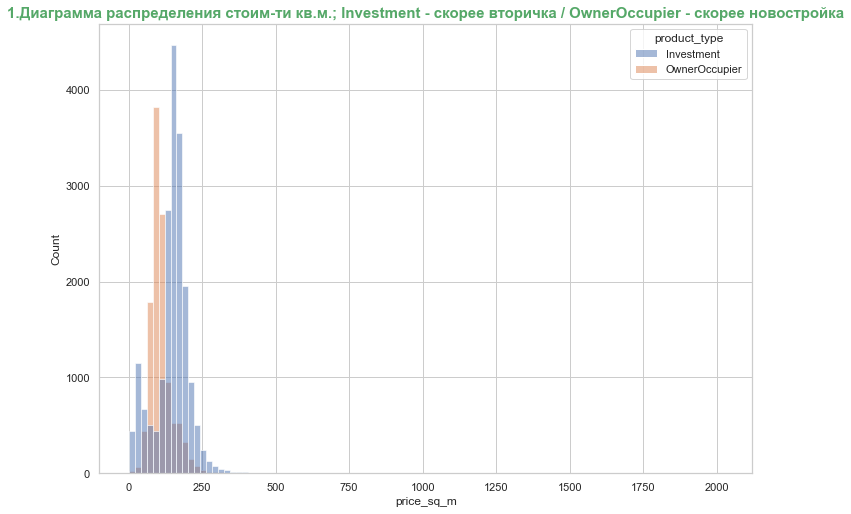

In [29]:
sns.set(style='whitegrid', color_codes=True,rc={'figure.figsize':(11.7,8.27)})

sns.histplot(
    data=train,
    x='price_sq_m',
    bins=100,
    hue=train.product_type,
)
plt.title('1.Диаграмма распределения стоим-ти кв.м.; Investment - скорее вторичка / OwnerOccupier - скорее новостройка', 
          size=15, color='g', weight='bold')
plt.show();

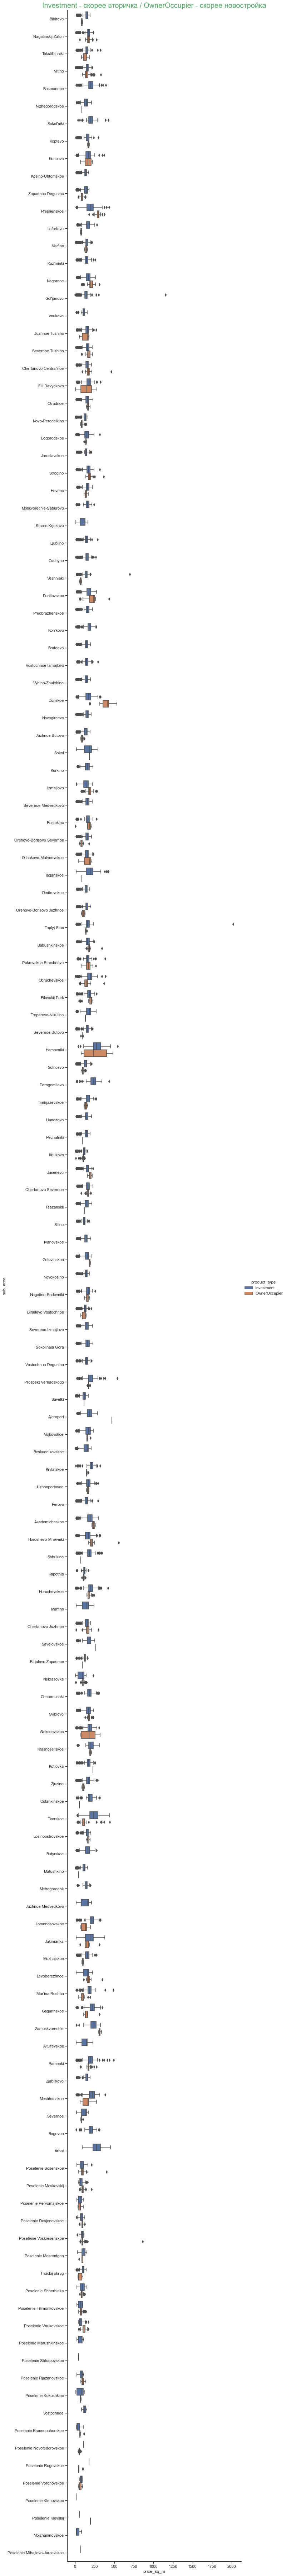

In [13]:
'''
Посмотрим зависимость стоимости кв.м в разных округах
'''

sns.set(style="ticks", color_codes=True)

sns.catplot(
    x='price_sq_m',
    y='sub_area', 
    data=train, 
    hue='product_type',    # оба на одном графике разными цветами
    height=100, 
    aspect=0.1, 
    kind='box', 
    dodge=True) 
# Можно использовать dodge=True чтобы не накладывать показатели друг на друга, а выстроить рядом друг с другом
plt.title('Investment - скорее вторичка / OwnerOccupier - скорее новостройка', size=20, color='g');

In [323]:
'''
В данных большое количество нереально низких стоимостей квадратного метра и некоторое количество очень больших.
Вероятно, присутствуют как ошибки, так и сознательное занижение стоимости, например, для ухода от налогов.
Исключим из данных заниженные и завышенные стоимости

Агрегация по округу и типу квартиры (новостройка/вторичка) для выбора границы заниженных цен
{'Investment': 0, 'OwnerOccupier': 1}
0 - вторичка
1 - новостройка
'''

agg_func = {
    'price_sq_m': ['count','std','min','max',perc_2, perc_3, perc_4, perc_5,perc_7,
                   perc_10,perc_12,perc_15,perc_17,perc_20,
                   perc_25,perc_50,perc_75,perc_90,perc_95, perc_97]
}

df=train.groupby(['sub_area','product_type']).agg(agg_func).round(1)
df.columns=df.columns.droplevel(0)

'''
После агрегации выбрал перцентили в качестве границы для отсечения слишком дешевых стоимостей по округам
'''
#df.xs('Investment', level=1).sort_values('count',ascending=False)
#df.xs('OwnerOccupier', level=1).sort_values('count',ascending=False)

train_temp=pd.merge(train,df[['perc_3','perc_4', 'perc_90']], how="left", on=["sub_area","product_type"])
#,'perc_10'

'''
Исключаем строки со стоимостью кв.м. ниже 4-го перцентиля во вторичке и ниже 3-го перцентиля в новостройках
по каждому из округов
'''
train=train_temp[((train_temp.product_type=='OwnerOccupier') & (train_temp.price_sq_m>=train_temp.perc_3)) | 
                      ((train_temp.product_type=='Investment') & (train_temp.price_sq_m>=train_temp.perc_4))]

'''
Исключаем строки с экстремально высокими значениями стоимости квадратного метра, 
выше 90 перцентиля по каждому из округов
'''
#train = train[train.price_sq_m <= 600]

train=train[train.price_sq_m <= train.perc_90]



'''
Удалим столбцы, которые не понадобятся
'''
train_drop_col=['timestamp','price_doc', 'perc_3', 'perc_4','perc_90','id']
#,'perc_10'
test_drop_col=['timestamp']

train = train.drop(columns = train_drop_col)
test = test.drop(columns = test_drop_col)


##################################################################################################################
'''
Присвоим столбцам, где по смыслу катеориальные признаки, тип данных "category"
'''
categ_col = [
    'year', 'month', 'dow', 'product_type', 'sub_area', 'ecology', 'state','material', 'ID_metro',
    'ID_railroad_station_walk', 'ID_railroad_station_avto', 'ID_big_road1','ID_big_road2', 'ID_railroad_terminal', 
    'ID_bus_terminal', 
    #'culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion',
    #'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion',
    #'detention_facility_raion', 'water_1line', 'big_road1_1line', 'railroad_1line'
]

for c in categ_col:
    train[c] = train[c].astype('category')
    test[c] = test[c].astype('category')

In [239]:
df.xs('Investment', level=1).sort_values('count',ascending=False)

,count,std,min,max,perc_2,perc_3,perc_4,perc_5,perc_7,perc_10,perc_12,perc_15,perc_17,perc_20,perc_25,perc_50,perc_75,perc_90,perc_95,perc_97
sub_area,,,,,,,,,,,,,,,,,,,,
Mar'ino,506,41.5,6.3,213.2,19.1,25.4,26.5,30.4,37.3,58.8,99.0,124.3,128.2,131.7,137.9,151.5,163.8,174.9,180.9,184.2
Juzhnoe Butovo,422,41.1,11.6,193.8,20.9,23.3,24.1,26.3,30.2,51.4,59.1,94.4,104.6,113.6,120.6,141.1,155.3,164.5,171.4,173.7
Otradnoe,351,49.1,12.7,230.5,15.9,18.9,25.4,26.9,38.1,50.0,60.3,95.3,100.4,122.1,136.0,160.0,175.0,187.0,193.0,198.7
Ljublino,296,43.1,12.0,288.9,21.5,24.1,26.2,29.1,36.7,48.8,67.5,116.3,123.0,128.6,132.9,146.9,160.0,172.3,178.6,183.0
Gol'janovo,294,75.8,1.4,1154.0,22.5,23.9,25.4,26.2,27.4,37.7,49.7,66.7,92.6,119.9,124.4,140.3,154.5,168.7,181.8,191.6
Krjukovo,277,35.6,5.3,155.6,13.7,14.7,19.2,19.6,24.4,27.1,33.9,73.6,89.4,100.2,108.3,117.0,126.2,133.3,138.5,141.7
Bogorodskoe,272,51.8,10.8,314.1,22.1,22.4,25.8,27.3,32.2,44.3,51.2,88.7,100.4,122.3,130.0,155.6,174.6,193.6,202.4,209.9
Vyhino-Zhulebino,264,41.9,9.8,196.7,21.9,22.6,25.6,27.9,37.0,48.7,67.5,114.5,119.9,125.7,129.1,146.9,159.1,167.7,173.1,178.3
Mitino,254,40.3,5.4,218.4,19.6,23.6,33.5,39.0,61.2,92.8,117.2,129.0,134.1,137.6,142.7,156.9,169.7,182.0,186.7,190.4


In [240]:
df.xs('OwnerOccupier', level=1).sort_values('count',ascending=False)

,count,std,min,max,perc_2,perc_3,perc_4,perc_5,perc_7,perc_10,perc_12,perc_15,perc_17,perc_20,perc_25,perc_50,perc_75,perc_90,perc_95,perc_97
sub_area,,,,,,,,,,,,,,,,,,,,
Poselenie Sosenskoe,1770,18.1,37.3,399.8,70.1,73.5,74.8,75.6,76.3,77.0,77.2,77.8,78.0,79.0,80.6,91.2,106.2,117.4,124.8,128.6
Nekrasovka,1668,12.7,9.8,232.9,77.7,80.7,81.6,81.7,84.2,87.5,88.5,90.0,91.3,92.2,93.7,101.8,106.5,113.9,121.5,124.2
Poselenie Vnukovskoe,1397,19.3,44.9,166.7,72.7,75.1,75.8,76.7,79.2,83.3,85.6,88.5,90.3,93.7,97.4,114.0,125.9,133.2,140.7,144.0
Poselenie Moskovskij,899,15.0,40.9,210.8,72.5,74.4,75.5,76.1,77.5,79.8,80.9,82.4,83.2,84.4,85.9,94.8,105.4,118.4,124.2,127.4
Poselenie Voskresenskoe,740,30.8,26.9,862.8,77.2,78.4,79.9,80.3,80.8,81.8,82.9,83.8,84.7,85.7,86.9,93.6,101.9,111.2,115.8,125.5
Poselenie Filimonkovskoe,547,14.3,47.3,137.8,52.2,54.1,54.7,55.5,57.7,58.4,59.3,60.8,61.3,62.2,65.2,73.5,80.4,90.6,101.5,109.4
Poselenie Shherbinka,430,10.9,58.8,123.4,66.5,68.5,69.4,70.3,71.5,72.5,73.4,74.5,75.3,76.3,77.5,82.5,89.6,99.7,106.3,108.9
Mitino,426,25.9,17.1,329.8,112.2,116.7,118.5,120.1,122.2,124.3,126.2,128.5,129.6,131.2,133.3,145.9,162.0,173.4,188.5,201.3
Poselenie Desjonovskoe,396,12.0,55.6,125.5,67.9,71.1,74.7,75.5,76.6,78.1,79.6,80.2,81.2,82.4,84.4,90.9,100.4,109.2,112.9,113.7


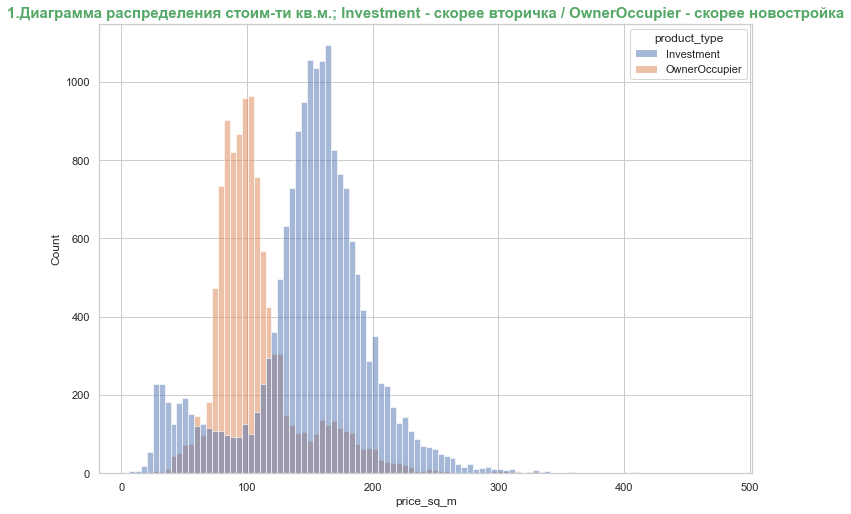

In [241]:
'''
Обновленная диаграмма после очистки стоимостей
'''

sns.set(style='whitegrid', color_codes=True,rc={'figure.figsize':(11.7,8.27)})

sns.histplot(
    data = train,
    x = 'price_sq_m',
    bins = 100,
    hue = train.product_type,
)
plt.title('1.Диаграмма распределения стоим-ти кв.м.; Investment - скорее вторичка / OwnerOccupier - скорее новостройка', 
          size=15, color='g', weight='bold')
plt.show();

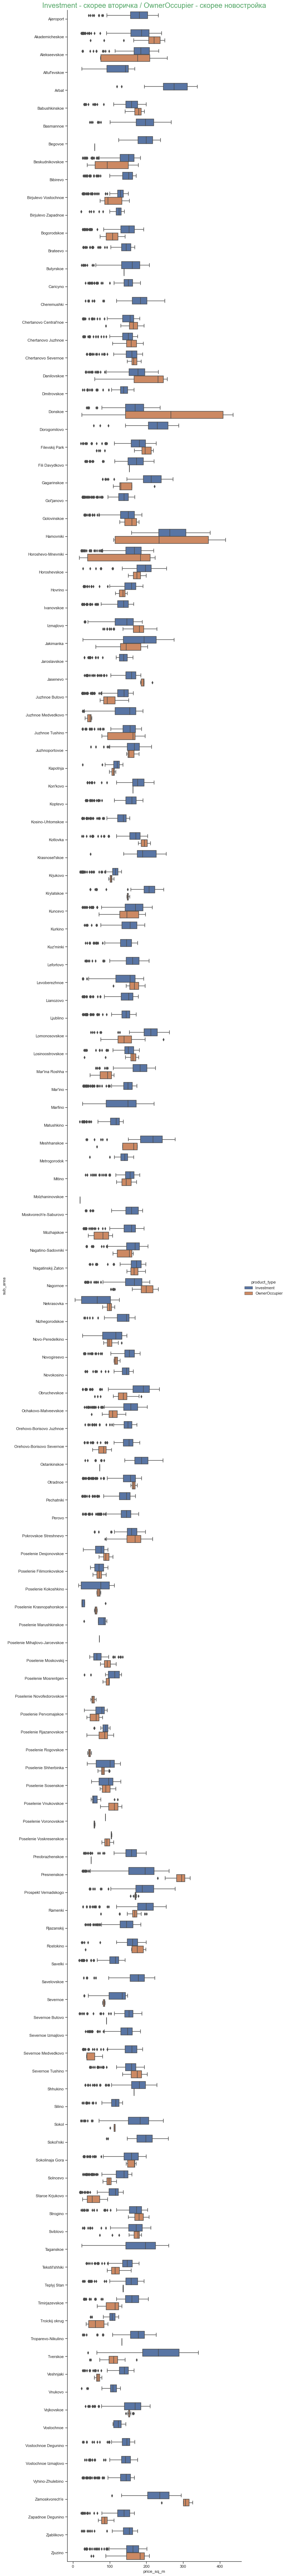

In [272]:
'''
Обновленная диаграмма зависимости стоимости кв.м в разных округах.
Очевидно, что осталось много заниженных стоимостей. Это видно на обоих графиках. На графике выше это синий горб в
левой части, на графике ниже это точки левее 25-го перцентиля.
В этой версии модели я их выбрасывать из данных для обучения не стал, т.к. опытным путем определил, что в тестовых
данных Kaggle заниженные стоимости также оставлены. С этими заниженными стоимостями результат на Kaggle получается 
значительно лучше.
Но если использовать модель для реальной жизни, например, проверки заявленной стоимости квартиры в заявках на ипотеку,
то эти заниженные стоимости надо вычищать.
'''

sns.set(style="ticks", color_codes=True)

sns.catplot(
    x='price_sq_m',
    y='sub_area', 
    data=train, 
    hue='product_type',    # оба на одном графике разными цветами
    height=100, 
    aspect=0.1, 
    kind='box', 
    dodge=True) 
# Можно использовать dodge=True чтобы не накладывать показатели друг на друга, а выстроить рядом друг с другом
plt.title('Investment - скорее вторичка / OwnerOccupier - скорее новостройка', size=20, color='g');

In [ ]:
'''
С учетом графика выше, видимо, надо делать разные модели для новостроек и вторички
'''
# описательная статитика по числовым полям
# train.describe().to_excel('train_describe.xlsx')

In [324]:
'''
Построим модель без исключения каких-либо столбцов и без деления на новостройка/вторичка
'''
train_temp_1 = train

y_train_1 = train_temp_1['price_sq_m']
X_train_1 = train_temp_1.drop(columns = ['price_sq_m'])
print(X_train_1.shape,y_train_1.shape)


#reg_lgbm = LGBMRegressor(learning_rate = 0.02999246953322253, max_depth = 5, n_estimators = 409)

reg_lgbm = LGBMRegressor()


kfold = KFold(n_splits=6, shuffle=True, random_state=42)

score_1 = make_scorer(mean_absolute_error)
score_2 = make_scorer(r2_score)
score_3 = make_scorer(mean_squared_log_error, squared=False)

#n=cross_val_score(reg_pipe,X_train_1, y_train_1, cv=kfold,scoring = score_1)
#print(f"LGBMRegressor mean_absolute: {np.mean(n):.4f}")
#print(f"folds mean_absolute: {n}")

#n=cross_val_score(LGBMRegressor(),X_train_1, y_train_1, cv=kfold,scoring = score_2)
#print(f"LGBMRegressor R2: {np.mean(n):.4f}")
#print(f"folds R2: {n}")



n=cross_val_score(reg_lgbm, X_train_1, y_train_1, cv=kfold,scoring = score_3)
print(f"mean_log_error: {np.mean(n):.4f}")
print(f"folds R2: {n}")

(26084, 292) (26084,)
mean_log_error: 0.3415
folds R2: [0.33057386 0.34586767 0.33654805 0.34941188 0.34242669 0.34394437]


In [309]:
#train.info(verbose=True,show_counts=True)

In [345]:
'''
Модель для загрузки на Kaggle - подготовка выборок
'''

train_temp_1 = train
test_1 = test

test_1 = test_1.drop(columns = ['price_doc'])

# делим обучающую выборку на две части по полю product_type
train_temp_1_Invest = train_temp_1[train_temp_1.product_type=='Investment']
train_temp_1_OwOc = train_temp_1[train_temp_1.product_type=='OwnerOccupier']

# train, test
y_train_1_Invest = train_temp_1_Invest['price_sq_m']
X_train_1_Invest = train_temp_1_Invest.drop(columns = ['price_sq_m','product_type'])
print(f"Investment shape: {X_train_1_Invest.shape},{y_train_1_Invest.shape}")

y_train_1_OwOc = train_temp_1_OwOc['price_sq_m']
X_train_1_OwOc = train_temp_1_OwOc.drop(columns = ['price_sq_m','product_type'])
print(f"OwnerOccupier shape: {X_train_1_OwOc.shape},{y_train_1_OwOc.shape}")



# делим тестовую выборку на две части по полю product_type
test_Invest = test_1[test_1.product_type=='Investment']
test_OwOc = test_1[test_1.product_type=='OwnerOccupier']

test_Invest_id = test_Invest['id']
test_OwOc_id = test_OwOc['id']

X_test_Invest = test_Invest.drop(columns = ['id','product_type'])
X_test_OwOc = test_OwOc.drop(columns = ['id','product_type'])
print(f"X_test_Invest, X_test_OwOc shape: {X_test_Invest.shape},{X_test_OwOc.shape}")


X_numerical_col_Invest = X_train_1_Invest.select_dtypes(include = [np.number]).columns
X_numerical_col_OwOc = X_train_1_OwOc.select_dtypes(include = [np.number]).columns


Investment shape: (16186, 291),(16186,)
OwnerOccupier shape: (9898, 291),(9898,)
X_test_Invest, X_test_OwOc shape: (4440, 291),(3222, 291)


In [370]:
%%time

'''
Модель для загрузки на Kaggle - подбор параметров для 1-ой части модели.
Это часть, где product_type = Investment (вторичка)

Проблема, которую не смог решить - не смог провести категориальные фичи через pipeline и columntransformer
с помощью remainder='passthrough' без применения onehotencoder и пр., чтобы lgbm принял их. 
Возникает ошибка - ValueError: could not convert string to float

'''

space_lgbm = {  
            'n_estimators':     hp.choice('n_estimators',     np.arange(100, 700, dtype=int)),
            'learning_rate':    hp.uniform('learning_rate',   0.001, 0.03),
            'max_depth':        hp.choice('max_depth',        np.arange(2, 16, dtype=int)),
            'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
            'subsample':        hp.uniform('subsample', 0.8, 1),
}


def hyperparameter_tuning(space):  #space, 
    # Инициализируем регрессор
    reg_lgbm_Invest = LGBMRegressor(**space)   #**space
    
    '''
    numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")), 
           ("scaler", StandardScaler())]#MinMaxScaler()
        
    )

    preprocessor = ColumnTransformer(
        transformers=[("num", numeric_transformer, X_numerical_col_Invest)]
        #, remainder='passthrough'
    )

    reg_pipe_Invest = Pipeline(
        steps=[("preprocessor", preprocessor), ("regression", reg_lgbm_Invest)]
    )
    '''
    
    kfold = KFold(n_splits=6, shuffle=True, random_state=42)
    score = make_scorer(mean_squared_log_error, squared=False)
    loss = np.mean(cross_val_score(reg_lgbm_Invest, X_train_1_Invest, y_train_1_Invest, cv=kfold,scoring = score))
 
    '''   
    # Обучение классификатора на данных для обучения
    reg_lgbm.fit(X_train_1_split, y_train_1_split)
    
    # Предсказание на тестовых данных
    pred = reg_lgbm.predict(X_test_1_split)
    
    # Расчет требуемой метрики качества - mean_log_error
    score = mean_squared_log_error(y_test_1_split, pred, squared=False)
    '''
    return {'loss': loss, 'status': STATUS_OK }



trials = Trials()
best = fmin(fn = hyperparameter_tuning,
            #X = X_train_1_Invest,
            #y = y_train_1_Invest,
            space = space_lgbm,
            algo = tpe.suggest,
            max_evals = 15,
            trials = trials)

print ('Invest:',best)
loss = trials.best_trial['result']['loss']
print ('loss Invest:', loss)



100%|████████████████████████████████████████████████| 15/15 [14:57<00:00, 59.87s/trial, best loss: 0.4212125411537759]
Invest: {'learning_rate': 0.015046104433395484, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 501, 'subsample': 0.850903786801252}
loss Invest: 0.4212125411537759
Wall time: 14min 58s


In [328]:
%%time
'''
Модель для загрузки на Kaggle - подбор параметров для 2-ой части модели.
Это часть, где product_type = OwnerOccupier (первичка)

Проблема, которую не смог решить - не смог провести категориальные фичи через pipeline и columntransformer
с помощью remainder='passthrough' без применения onehotencoder и пр., чтобы lgbm принял их. 
Возникает ошибка - ValueError: could not convert string to float

'''

def hyperparameter_tuning(space):  #space, 
    # Инициализируем регрессор
    reg_lgbm_OwOc = LGBMRegressor(**space)   #**space

    '''
    numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(missing_values=np.nan, strategy="median")), 
           ("scaler", StandardScaler())] #MinMaxScaler()
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, X_numerical_col_OwOc),
            #("cat", categorical_transformer, categorical_features),
        ]
    )

    reg_pipe_OwOc = Pipeline(
        steps=[("preprocessor", preprocessor), ("regression", reg_lgbm_OwOc)]
    )
    '''
    
    kfold = KFold(n_splits=6, shuffle=True, random_state=42)
    score = make_scorer(mean_squared_log_error, squared=False)
    loss = np.mean(cross_val_score(reg_lgbm_OwOc, X_train_1_OwOc, y_train_1_OwOc, cv=kfold,scoring = score))
 
    return {'loss': loss, 'status': STATUS_OK }




trials = Trials()

best = fmin(fn = hyperparameter_tuning,
            space = space_lgbm,
            algo = tpe.suggest,
            max_evals = 15,
            trials = trials)

print ('OwOc:', best)
loss = trials.best_trial['result']['loss']
print ('loss OwOc:', loss)


100%|███████████████████████████████████████████████| 15/15 [07:49<00:00, 31.33s/trial, best loss: 0.10597964837689865]
OwOc: {'learning_rate': 0.02784644354057584, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 592, 'subsample': 0.9016631125458168}
loss OwOc: 0.10597964837689865


In [371]:
%%time

'''
Модель для загрузки на Kaggle
Обучение и предсказание после выбора оптимальных параметров моделей
'''
#Invest: {'learning_rate': 0.015046104433395484, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 501, 
#'subsample': 0.850903786801252}

reg_lgbm_Invest = LGBMRegressor(
            n_estimators =     501, 
            learning_rate =    0.015046104433395484, 
            max_depth =        3, 
            min_child_weight = 4, 
            subsample =        0.850903786801252, 
           
)

'''
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")), 
           ("scaler", StandardScaler())] #MinMaxScaler()
    )

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, X_numerical_col_Invest)
            #("cat", categorical_transformer, categorical_features),
        ], remainder='passthrough'
    
    )

reg_pipe_Invest = Pipeline(steps=[("preprocessor", preprocessor), ("regression", reg_lgbm_Invest)])
'''

reg_lgbm_Invest.fit(X_train_1_Invest, y_train_1_Invest)
y_pred_Invest=reg_lgbm_Invest.predict(X_test_Invest)




#OwOc: {'learning_rate': 0.02784644354057584, 'max_depth': 8, 'min_child_weight': 1, 
#       'n_estimators': 592, 'subsample': 0.9016631125458168}
reg_lgbm_OwOc = LGBMRegressor(
            n_estimators =     592, 
            learning_rate =    0.02784644354057584, 
            max_depth =        8, 
            min_child_weight = 1, 
            subsample =        0.9016631125458168, 
)
reg_lgbm_OwOc.fit(X_train_1_OwOc, y_train_1_OwOc)
y_pred_OwOc=reg_lgbm_OwOc.predict(X_test_OwOc)
#'''

Wall time: 12.9 s


In [372]:
'''
Модель для загрузки на Kaggle
Подготовка файла для загрузки.

Лучший результат, который пока получился:
Private score: 0.32538
Public score: 0.32561
Это примерно место 1801 из 3265


Еще лучше вариант модели получился дальше после исключения части признаков
Private score: 0.32078
Public score: 0.32218
Это примерно место 1326 из 3265
'''

y_pred_Invest = pd.Series(y_pred_Invest,name='price_sq_m')
Y_test_Invest = pd.concat([X_test_Invest.full_sq.reset_index(),test_Invest_id.reset_index(), y_pred_Invest], axis=1)

y_pred_OwOc = pd.Series(y_pred_OwOc,name='price_sq_m')
Y_test_OwOc = pd.concat([X_test_OwOc.full_sq.reset_index(),test_OwOc_id.reset_index(), y_pred_OwOc], axis=1)

Y_test = pd.concat([Y_test_Invest,Y_test_OwOc], axis=0).sort_values('id')
Y_test['price_doc'] = (Y_test.full_sq * Y_test.price_sq_m * 1000).round(2)
Y_test = Y_test.drop(columns = ['index', 'full_sq', 'price_sq_m'])
Y_test.set_index(['id']).to_csv('Y_test.csv', sep = ',')

In [ ]:
'''
Далее решению задачи по сокращению количества признаков при несущественном снижении качества 
'''

In [373]:
'''
В качестве точки осчета или "эталонного" результата возьмем модель с лучшим результатом на kaggle и 
рассчитаем метрики качесва на тестовых данных.
Результаты после исключения признаков будем сравнивать с этими метриками
'''
train_temp_1 = train

# делим обучающую выборку на две части по полю product_type
train_temp_1_Invest = train_temp_1[train_temp_1.product_type=='Investment']
train_temp_1_OwOc = train_temp_1[train_temp_1.product_type=='OwnerOccupier']

# train, test
y_train_1_Invest = train_temp_1_Invest['price_sq_m']
X_train_1_Invest = train_temp_1_Invest.drop(columns = ['price_sq_m','product_type'])
print(f"Investment shape: {X_train_1_Invest.shape},{y_train_1_Invest.shape}")

y_train_1_OwOc = train_temp_1_OwOc['price_sq_m']
X_train_1_OwOc = train_temp_1_OwOc.drop(columns = ['price_sq_m','product_type'])
print(f"OwnerOccupier shape: {X_train_1_OwOc.shape},{y_train_1_OwOc.shape}")


kfold = KFold(n_splits=6, shuffle=True, random_state=42)

score_1 = make_scorer(mean_absolute_error)
score_2 = make_scorer(r2_score)
score_3 = make_scorer(mean_squared_log_error, squared=False)


reg_lgbm_Invest = LGBMRegressor(
            n_estimators =     501, 
            learning_rate =    0.015046104433395484, 
            max_depth =        3, 
            min_child_weight = 4, 
            subsample =        0.850903786801252, 
           
)

reg_lgbm_OwOc = LGBMRegressor(
            n_estimators =     592, 
            learning_rate =    0.02784644354057584, 
            max_depth =        8, 
            min_child_weight = 1, 
            subsample =        0.9016631125458168, 
)


n=cross_val_score(reg_lgbm_Invest,X_train_1_Invest, y_train_1_Invest, cv=kfold,scoring = score_1)
print(f"\nInvestment mean_absolute: {np.mean(n):.4f}")
print(f"folds mean_absolute: {n}")
n2=cross_val_score(reg_lgbm_Invest,X_train_1_Invest, y_train_1_Invest, cv=kfold,scoring = score_3)
print(f"\nInvestment mean_log_error: {np.mean(n2):.4f}")
print(f"folds mean_log_error: {n2}")

n=cross_val_score(reg_lgbm_OwOc, X_train_1_OwOc, y_train_1_OwOc, cv=kfold,scoring = score_1)
print(f"\nOwnerOccupier mean_absolute: {np.mean(n):.4f}")
print(f"folds mean_absolute: {n}")
n2=cross_val_score(reg_lgbm_OwOc, X_train_1_OwOc, y_train_1_OwOc, cv=kfold,scoring = score_3)
print(f"\nOwnerOccupier mean_log_error: {np.mean(n2):.4f}")
print(f"folds mean_log_error: {n2}")


Investment shape: (16186, 291),(16186,)
OwnerOccupier shape: (9898, 291),(9898,)

Investment mean_absolute: 27.2650
folds mean_absolute: [27.64372263 26.66373089 27.39327591 27.22942016 27.6337993  27.02607171]

Investment mean_log_error: 0.4232
folds mean_log_error: [0.42595927 0.40991559 0.4229807  0.42827936 0.42125239 0.4307097 ]

OwnerOccupier mean_absolute: 5.7186
folds mean_absolute: [5.7538095  5.70221878 5.65817677 5.47397035 5.6653814  6.05775638]

OwnerOccupier mean_log_error: 0.1069
folds mean_log_error: [0.09339181 0.09772838 0.1061481  0.11557949 0.1035757  0.12520543]


In [375]:
'''
Таблица значимости признаков для 1-й части модели
'''

reg_lgbm_Invest.fit(X_train_1_Invest, y_train_1_Invest)
pd.DataFrame({'feature_Invest': reg_lgbm_Invest.feature_name_, 
              'importance_Invest': reg_lgbm_Invest.feature_importances_}).sort_values(by='importance_Invest',ascending=False)

,feature,importance
9,sub_area,678
81,ID_metro,597
5,build_year,222
288,year,169
99,ID_railroad_station_avto,164
0,full_sq,157
96,ID_railroad_station_walk,125
3,max_floor,121
2,floor,115
1,life_sq,78


In [377]:
'''
Таблица значимости признаков для 2-й части модели
'''

reg_lgbm_OwOc.fit(X_train_1_OwOc, y_train_1_OwOc)
pd.DataFrame({'feature_OwOc': reg_lgbm_OwOc.feature_name_, 
              'importance_OwOc': reg_lgbm_OwOc.feature_importances_}).sort_values(by='importance_OwOc',ascending=False)

,feature_OwOc,importance_OwOc
0,full_sq,1666
2,floor,896
1,life_sq,833
289,month,732
9,sub_area,599
288,year,560
3,max_floor,496
5,build_year,393
6,num_room,369
81,ID_metro,319


In [492]:
'''
Исключим по одному столбцу из всех пар, корреляция у которых между собой более 0.6
Для 1-ой части - из 291 столбца осталось 93

Использую функцию из самого начала этого ноутбука
'''

X_train_1_Invest_temp = X_train_1_Invest

X_train_1_Invest_temp = remove_collinear_features(X_train_1_Invest_temp, 0.6)

X_train_1_Invest_temp.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16186 entries, 0 to 30470
Data columns (total 93 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   full_sq                                16186 non-null  float64 
 1   life_sq                                16094 non-null  float64 
 2   floor                                  16115 non-null  float64 
 3   max_floor                              14043 non-null  float64 
 4   material                               14072 non-null  category
 5   build_year                             14020 non-null  float64 
 6   kitch_sq                               14008 non-null  float64 
 7   state                                  9954 non-null   category
 8   sub_area                               16186 non-null  category
 9   area_m                                 16186 non-null  float64 
 10  raion_popul                            16186 non-null  flo

In [435]:
'''
Исключим по одному столбцу из всех пар, корреляция у которых между собой более 0.6
Для 1-ой части - из 291 столбца осталось 61
'''
X_train_1_OwOc_temp = X_train_1_OwOc

X_train_1_OwOc_temp = remove_collinear_features(X_train_1_OwOc_temp, 0.60)

X_train_1_OwOc_temp.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9898 entries, 28 to 30464
Data columns (total 61 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   full_sq                                9898 non-null   float64 
 1   life_sq                                3982 non-null   float64 
 2   floor                                  9813 non-null   float64 
 3   max_floor                              9574 non-null   float64 
 4   material                               9694 non-null   category
 5   build_year                             9416 non-null   float64 
 6   kitch_sq                               8942 non-null   float64 
 7   state                                  4020 non-null   category
 8   sub_area                               9898 non-null   category
 9   area_m                                 9898 non-null   float64 
 10  raion_popul                            9898 non-null   flo

In [493]:
'''
Сравним метрики после исключения колинеарных признаков при уровне 0.6. Ранее было так:
Investment mean_log_error: 0.4232
OwnerOccupier mean_log_error: 0.1069. Результат изменился не очень существенно.

Что интересно, результат после загрузки на Kaggle при уровне 0.8 для второй части получился заметно лучше:
Private score: 0.32078
Public score: 0.32218
'''

reg_lgbm_Invest = LGBMRegressor(
            n_estimators =     501, 
            learning_rate =    0.015046104433395484, 
            max_depth =        3, 
            min_child_weight = 4, 
            subsample =        0.850903786801252, 
           
)

reg_lgbm_OwOc = LGBMRegressor(
            n_estimators =     592, 
            learning_rate =    0.02784644354057584, 
            max_depth =        8, 
            min_child_weight = 1, 
            subsample =        0.9016631125458168, 
)
#'''
n2=cross_val_score(reg_lgbm_Invest,X_train_1_Invest_temp, y_train_1_Invest, cv=kfold,scoring = score_3)
print(f"\nInvestment mean_log_error: {np.mean(n2):.4f}")
print(f"folds mean_log_error: {n2}")
#'''
n2=cross_val_score(reg_lgbm_OwOc, X_train_1_OwOc_temp, y_train_1_OwOc, cv=kfold,scoring = score_3)
print(f"\nOwnerOccupier mean_log_error: {np.mean(n2):.4f}")
print(f"folds mean_log_error: {n2}")


Investment mean_log_error: 0.4236
folds mean_log_error: [0.42596583 0.41022308 0.42316466 0.42895363 0.42213737 0.43139645]

OwnerOccupier mean_log_error: 0.1065
folds mean_log_error: [0.09177586 0.10091777 0.10547944 0.11445928 0.10702212 0.11937767]


In [494]:
'''
Таблица значимости признаков для 1-й части модели после исключения коллинеарных признаков
'''
reg_lgbm_Invest.fit(X_train_1_Invest_temp, y_train_1_Invest)
feature_imp_Invest = pd.DataFrame({'feature_Invest': reg_lgbm_Invest.feature_name_, 
              'importance_Invest': reg_lgbm_Invest.feature_importances_}).sort_values(by='importance_Invest',
                                                                                      ascending=False)
feature_imp_Invest

,feature_Invest,importance_Invest
8,sub_area,751
36,ID_metro,672
5,build_year,248
48,ID_railroad_station_avto,187
90,year,185
47,ID_railroad_station_walk,174
0,full_sq,158
3,max_floor,135
2,floor,106
1,life_sq,93


In [495]:
'''
Таблица значимости признаков для 2-й части модели после исключения коллинеарных признаков
'''

reg_lgbm_OwOc.fit(X_train_1_OwOc_temp, y_train_1_OwOc)
feature_imp_OwOc = pd.DataFrame({'feature_OwOc': reg_lgbm_OwOc.feature_name_, 
              'importance_OwOc': reg_lgbm_OwOc.feature_importances_}).sort_values(by='importance_OwOc',
                                                                                  ascending=False)
feature_imp_OwOc

,feature_OwOc,importance_OwOc
0,full_sq,2026
2,floor,1083
1,life_sq,1003
14,hospital_beds_raion,774
59,month,740
8,sub_area,733
3,max_floor,727
5,build_year,663
58,year,624
31,cemetery_km,572


In [496]:
'''
Посмотрим зависимость метрики качества модели от количества признаков в модели
'''
def number_feature_model(X_train_1_Invest_temp, X_train_1_OwOc_temp):
    reg_lgbm_Invest = LGBMRegressor(
                n_estimators =     501, 
                learning_rate =    0.015046104433395484, 
                max_depth =        3, 
                min_child_weight = 4, 
                subsample =        0.850903786801252, 
           
    )

    reg_lgbm_OwOc = LGBMRegressor(
                n_estimators =     592, 
                learning_rate =    0.02784644354057584, 
                max_depth =        8, 
                min_child_weight = 1, 
                subsample =        0.9016631125458168, 
    )
    #'''
    n1=cross_val_score(reg_lgbm_Invest,X_train_1_Invest_temp, y_train_1_Invest, cv=kfold,scoring = score_3)
    #print(f"\nInvestment mean_log_error: {np.mean(n2):.4f}")
    #print(f"folds mean_log_error: {n2}")
    #'''
    n2=cross_val_score(reg_lgbm_OwOc, X_train_1_OwOc_temp, y_train_1_OwOc, cv=kfold,scoring = score_3)
    #print(f"\nOwnerOccupier mean_log_error: {np.mean(n2):.4f}")
    #print(f"folds mean_log_error: {n2}")
    return [np.mean(n1), np.mean(n2)]

In [497]:
%%time
'''
Цикл для расчета метрик для различного числа признаков
'''

Invest_metrics=[]
OwOc_metrics = []
for i in range(2, 52, 2):
    X_Invest_temp = X_train_1_Invest_temp[feature_imp_Invest.head(i).feature_Invest]
    X_OwOc_temp = X_train_1_OwOc_temp[feature_imp_OwOc.head(i).feature_OwOc]
    Invest_metrics.append(number_feature_model(X_Invest_temp, X_OwOc_temp)[0])
    OwOc_metrics.append(number_feature_model(X_Invest_temp, X_OwOc_temp)[1])

Wall time: 11min


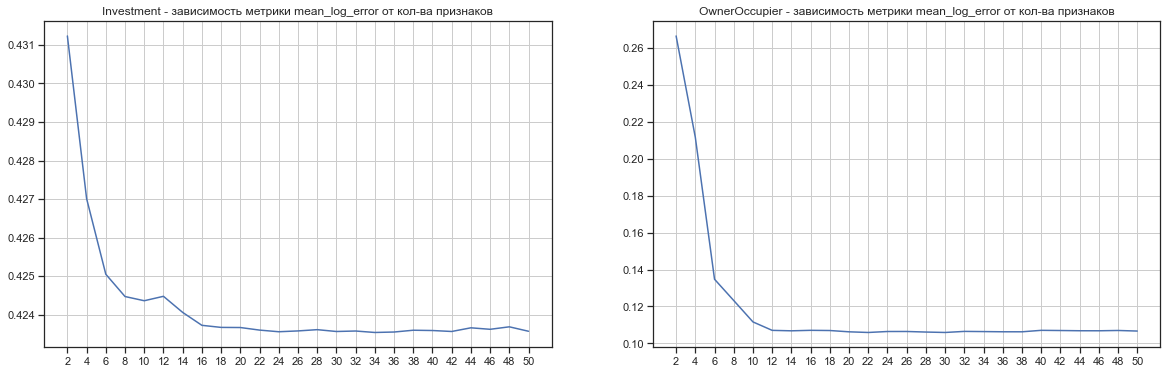

In [498]:
'''
Для первой части модели можно взять 16 самых значимых признаков, для второй части модели 12 самых значимых признаков
'''
fig, ax = plt.subplots(nrows=1,ncols=2)
ax1, ax2 = ax.flatten()

ax1.plot(range(2, 52, 2), Invest_metrics)
ax1.set_title('Investment - зависимость метрики mean_log_error от кол-ва признаков')

ax2.plot(range(2, 52, 2), OwOc_metrics)
ax2.set_title('OwnerOccupier - зависимость метрики mean_log_error от кол-ва признаков')
fig.set_size_inches(20,6)

ax1.set_xticks(np.arange(2, 52, step=2))
ax2.set_xticks(np.arange(2, 52, step=2))

ax1.grid()
ax2.grid()

plt.show()

In [ ]:
'''
Ниже модель, с которой получился пока лучший результат при загрузке на Kaggle.
Использованы все признаки из первой части модели, а во второй части модели исключены коллинеарные признаки 
с границей 0.8
'''

In [432]:
%%time

'''
Модель для загрузки на Kaggle - подбор параметров для 1-ой части модели.
Это часть, где product_type = Investment (вторичка)

'''
X_numerical_col_Invest = X_train_1_Invest_temp.select_dtypes(include = [np.number]).columns
X_categorial_col_Invest = X_train_1_Invest_temp.select_dtypes(exclude = [np.number]).columns

X_numerical_col_OwOc = X_train_1_OwOc_temp.select_dtypes(include = [np.number]).columns
X_categorial_col_OwOc = X_train_1_OwOc_temp.select_dtypes(exclude = [np.number]).columns


space_lgbm = {  
            'n_estimators':     hp.choice('n_estimators',     np.arange(100, 700, dtype=int)),
            'learning_rate':    hp.uniform('learning_rate',   0.001, 0.03),
            'max_depth':        hp.choice('max_depth',        np.arange(2, 16, dtype=int)),
            'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
            'subsample':        hp.uniform('subsample', 0.8, 1),
}


def hyperparameter_tuning(space):  #space, 
    # Инициализируем регрессор
    reg_lgbm_Invest = LGBMRegressor(**space)   #**space
    
    #'''
    numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")), 
           ("scaler", StandardScaler())] #MinMaxScaler()
    )

    categorical_transformer = OneHotEncoder(handle_unknown="ignore")

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, X_numerical_col_Invest),
            ("cat", categorical_transformer, X_categorial_col_Invest)
            ]
    #, remainder='passthrough'
    
    )

    reg_pipe_Invest = Pipeline(steps=[("preprocessor", preprocessor), ("regression", reg_lgbm_Invest)])


    #'''
    
    kfold = KFold(n_splits=6, shuffle=True, random_state=42)
    score = make_scorer(mean_squared_log_error, squared=False)
    loss = np.mean(cross_val_score(reg_pipe_Invest, X_train_1_Invest_temp, y_train_1_Invest, cv=kfold,scoring = score))
 
    return {'loss': loss, 'status': STATUS_OK }



trials = Trials()
best = fmin(fn = hyperparameter_tuning,
            #X = X_train_1_Invest,
            #y = y_train_1_Invest,
            space = space_lgbm,
            algo = tpe.suggest,
            max_evals = 15,
            trials = trials)

print ('Invest:',best)
loss = trials.best_trial['result']['loss']
print ('loss Invest:', loss)


100%|███████████████████████████████████████████████| 15/15 [12:44<00:00, 50.97s/trial, best loss: 0.42073079927323404]
Invest: {'learning_rate': 0.019202327930907613, 'max_depth': 13, 'min_child_weight': 4, 'n_estimators': 431, 'subsample': 0.8530417840957498}
loss Invest: 0.42073079927323404
Wall time: 12min 44s


In [427]:
%%time
'''
Модель для загрузки на Kaggle - подбор параметров для 2-ой части модели.
Это часть, где product_type = OwnerOccupier (первичка)

Проблема, которую не смог решить - не смог провести категориальные фичи через pipeline и columntransformer
с помощью remainder='passthrough' без применения onehotencoder и пр., чтобы lgbm принял их. 
Возникает ошибка - ValueError: could not convert string to float

'''

def hyperparameter_tuning(space):  #space, 
    # Инициализируем регрессор
    reg_lgbm_OwOc = LGBMRegressor(**space)   #**space

       
    kfold = KFold(n_splits=6, shuffle=True, random_state=42)
    score = make_scorer(mean_squared_log_error, squared=False)
    loss = np.mean(cross_val_score(reg_lgbm_OwOc, X_train_1_OwOc_temp, y_train_1_OwOc, cv=kfold,scoring = score))
 
    return {'loss': loss, 'status': STATUS_OK }




trials = Trials()

best = fmin(fn = hyperparameter_tuning,
            space = space_lgbm,
            algo = tpe.suggest,
            max_evals = 30,
            trials = trials)

print ('OwOc:', best)
loss = trials.best_trial['result']['loss']
print ('loss OwOc:', loss)

100%|███████████████████████████████████████████████| 30/30 [06:54<00:00, 13.82s/trial, best loss: 0.10503555148802013]
OwOc: {'learning_rate': 0.02734739405873579, 'max_depth': 11, 'min_child_weight': 6, 'n_estimators': 570, 'subsample': 0.8426057635708013}
loss OwOc: 0.10503555148802013
Wall time: 6min 54s


In [429]:
X_numerical_col_Invest = X_train_1_Invest_temp.select_dtypes(include = [np.number]).columns
X_categorial_col_Invest = X_train_1_Invest_temp.select_dtypes(exclude = [np.number]).columns
X_categorial_col_Invest

Index(['material', 'state', 'sub_area', 'ID_metro', 'ID_railroad_station_walk',
       'ID_railroad_station_avto', 'ID_big_road1', 'ID_big_road2',
       'ID_railroad_terminal', 'ID_bus_terminal', 'ecology', 'year', 'month',
       'dow'],
      dtype='object')

In [433]:
'''
Модель для загрузки на Kaggle
Обучение и предсказание после отбрасывания колинеарных признаков:
оставлены все признаки  на 1-ой части, на второй части использован treshold 0.8

Что интересно, результат после загрузки на Kaggle  получился заметно лучше:
Private score: 0.32078
Public score: 0.32218
'''
#'''

X_numerical_col_Invest = X_train_1_Invest_temp.select_dtypes(include = [np.number]).columns
X_categorial_col_Invest = X_train_1_Invest_temp.select_dtypes(exclude = [np.number]).columns

X_numerical_col_OwOc = X_train_1_OwOc_temp.select_dtypes(include = [np.number]).columns
X_categorial_col_OwOc = X_train_1_OwOc_temp.select_dtypes(exclude = [np.number]).columns

Inv_col = X_train_1_Invest_temp.columns
X_test_Invest_temp = X_test_Invest[Inv_col]

OwOc_col = X_train_1_OwOc_temp.columns
X_test_OwOc_temp = X_test_OwOc[OwOc_col]

#Invest: {'learning_rate': 0.015046104433395484, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 501, 
#'subsample': 0.850903786801252}
#Invest: {'learning_rate': 0.019202327930907613, 'max_depth': 13, 'min_child_weight': 4, 'n_estimators': 431, 
#'subsample': 0.8530417840957498}
#loss Invest: 0.42073079927323404

reg_lgbm_Invest = LGBMRegressor(
            n_estimators =     431, 
            learning_rate =    0.019202327930907613, 
            max_depth =        13, 
            min_child_weight = 4, 
            subsample =        0.8530417840957498, 
           
)




numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")), 
           ("scaler", StandardScaler())] #MinMaxScaler()
    )

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, X_numerical_col_Invest),
        ("cat", categorical_transformer, X_categorial_col_Invest)
        ]
    #, remainder='passthrough'
    
    )

reg_pipe_Invest = Pipeline(steps=[("preprocessor", preprocessor), ("regression", reg_lgbm_Invest)])




reg_pipe_Invest.fit(X_train_1_Invest_temp, y_train_1_Invest)
y_pred_Invest = reg_pipe_Invest.predict(X_test_Invest_temp)




#OwOc: {'learning_rate': 0.02784644354057584, 'max_depth': 8, 'min_child_weight': 1, 
#       'n_estimators': 592, 'subsample': 0.9016631125458168}

#OwOc: {'learning_rate': 0.02734739405873579, 'max_depth': 11, 'min_child_weight': 6, 
#'n_estimators': 570, 'subsample': 0.8426057635708013}     loss OwOc: 0.10503555148802013

reg_lgbm_OwOc = LGBMRegressor(
            n_estimators =     592, 
            learning_rate =    0.02784644354057584, 
            max_depth =        8, 
            min_child_weight = 1, 
            subsample =        0.9016631125458168, 
)

'''
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")), 
           ("scaler", StandardScaler())] #MinMaxScaler()
    )

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, X_numerical_col_OwOc),
        ("cat", categorical_transformer, X_categorial_col_OwOc)
        ]
    #, remainder='passthrough'
    
    )

reg_pipe_OwOc = Pipeline(steps=[("preprocessor", preprocessor), ("regression", reg_lgbm_OwOc)])

'''

reg_lgbm_OwOc.fit(X_train_1_OwOc_temp, y_train_1_OwOc)
y_pred_OwOc = reg_lgbm_OwOc.predict(X_test_OwOc_temp)

#'''
y_pred_Invest = pd.Series(y_pred_Invest,name='price_sq_m')
Y_test_Invest = pd.concat([X_test_Invest_temp.full_sq.reset_index(),test_Invest_id.reset_index(), y_pred_Invest], axis=1)

y_pred_OwOc = pd.Series(y_pred_OwOc,name='price_sq_m')
Y_test_OwOc = pd.concat([X_test_OwOc_temp.full_sq.reset_index(),test_OwOc_id.reset_index(), y_pred_OwOc], axis=1)

Y_test = pd.concat([Y_test_Invest,Y_test_OwOc], axis=0).sort_values('id')
Y_test['price_doc'] = (Y_test.full_sq * Y_test.price_sq_m * 1000).round(2)
Y_test = Y_test.drop(columns = ['index', 'full_sq', 'price_sq_m'])
Y_test.set_index(['id']).to_csv('Y_test.csv', sep = ',')
#'''